# Erzeugung von Trackausschnitten

Um die satellitenbasierten Eigenschaften der nach der Filterung verbliebenen HACI-Fälle zu untersuchen, benötigen wir lagrangesche Ausschnitte der Trackdaten. Dabei gehen wir wie folgt vor:

1. Schwerpunkt des HACI-Objektes zum CI-Zeitpunkt ist der Startpunkt.
2. Parallaxenkorrektur des IR&thinsp;10,8&thinsp;µm-Feldes des Startzeitpunktess mit der geglätteten NWCSAF-Wolkenhöhe.
2. Berechnung von Verschiebungsvektoren mit Optical Flow auf Basis des parallaxenkorrigierten IR&thinsp;10,8&thinsp;µm-Feldes.
3. Verschiebung des Startpunktes ensprechend der Verschiebungsvektoren. 
4. Wiederholung der Schritte 2 bis 4 für 30&thinsp;min vor und nach dem Startzeitpunkt.
6. Erzeuge 51&thinsp;px&times;&thinsp;51&thinsp;px - Ausschnitte der parallaxenkorrigierten MSG-Daten um die Trackpunkte.
7. Speichere den Track und die Trackausschnitte.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from analysis_tools import grid_and_interpolation as gi
from standard_config import *

import MSGtools as mst
from l15_msevi import msevi_config

import sys
sys.path.append("{}/utils/tracking".format(local_home_path))
sys.path.append("{}/utils".format(local_home_path))
import load_satellite_data as lsd

sys.path.append("{}/utils/tracking".format(local_home_path))
import tracking_common as tco

from io_tools import radolan

import geooperations as go
import os

import datetime as dt

r = radolan.Radolan()

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [45]:
import matplotlib.pyplot as plt

## 1. Position des HACI-Objektes

In [10]:
haci_objects = pd.read_csv("{}/HACI_bbox_data/haci_objects.dat".format(local_data_path),sep="\s+")

In [19]:
DT = haci_objects.t1 - haci_objects.t0
haci_objects = haci_objects.assign(dt=DT)

In [25]:
example_object = haci_objects[(haci_objects.date=="2013-06-18") & (haci_objects.dt>=6) & (haci_objects.time=="12:55")]

In [29]:
example_object

date   time    id  flags   t0   t1  l00  l01  c00  c01   l0  \
6103938  2013-06-18  12:55  1614      0  155  161  393  396  625  628  391   

          l1   c0   c1  dt  
6103938  398  625  635   6

In [77]:
start_row = example_object.l0 + (example_object.l1 - example_object.l0) // 2
start_row = start_row.values[0]

In [78]:
start_col = example_object.c0 + (example_object.c1 - example_object.c0) // 2
start_col = start_col.values[0]

In [79]:
start_lon = r.lon[start_row,start_col]
start_lat = r.lat[start_row,start_col]

In [80]:
print("lon = {}\nlat = {}".format(start_lon, start_lat))

lon = 11.431044539553598
lat = 50.51511753755318


## 2. Parallaxenkorrektur 

Für die Parallaxenkorrektur laden wir uns die NWCSAF-Wolkenhöhe und IR108 für den Startzeitpunkt.

In [38]:
start_time = dt.datetime(2013,6,18,12,55)

In [48]:
time_steps = pd.date_range(start="20130618T1225",
                           end = "20130618T1325",
                           freq = "5min")

In [42]:
cth = mst.get_nwcsaf_prod("CTTH_HEIGHT",start_time,calibrate=True)
ir108 = lsd.load_satellite_data(start_time,"IR_108")
slon,slat = mst.get_msg_lon_lat(region='eu')

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Region suggests use of hdf file


Als nächstes führen wir die Parallaxenkorrektur durch.

In [43]:
ir108_corrected = go.parallax_correct_msg(ir108,slon,slat,cth,'std','eu','rss',3)

Text(0.5, 1.0, 'IR 10,8 µm parallaxenkorrigiert')

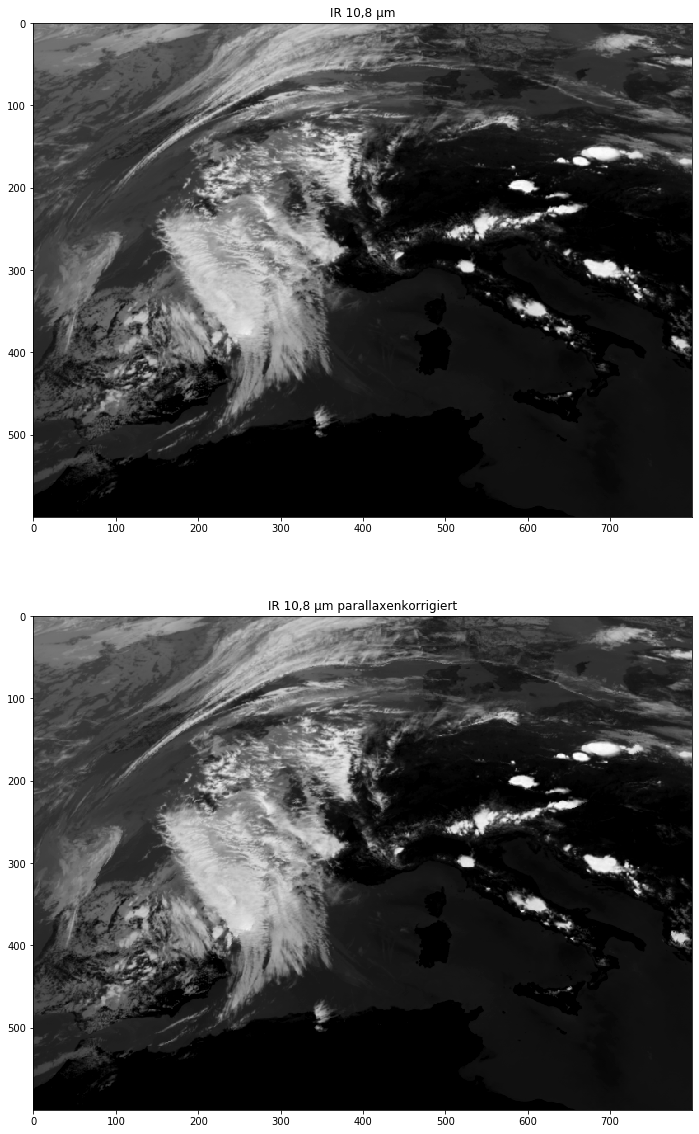

In [47]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
ax[0].imshow(ir108,vmin=210,vmax=300,cmap='gray_r')
ax[0].set_title("IR 10,8 µm")

ax[1].imshow(ir108_corrected,vmin=210,vmax=300,cmap='gray_r')
ax[1].set_title("IR 10,8 µm parallaxenkorrigiert")

## 3 Trackausschnitte

Für den Track brauchen wir auch noch die Daten für alle Trackzeitschritte.

In [50]:
time_steps = pd.date_range(start="20130618T1225",
                           end = "20130618T1325",
                           freq = "5min")

In [49]:
sat_data = {'IR_108':[],
            'cth':[]}

In [51]:
for t in time_steps:
    cth = mst.get_nwcsaf_prod("CTTH_HEIGHT",t.to_pydatetime(),calibrate=True)
    ir108 = lsd.load_satellite_data(t.to_pydatetime(),"IR_108") 
    ir108_corrected = go.parallax_correct_msg(ir108,slon,slat,cth,'std','eu','rss',3)
    sat_data['IR_108'].append(ir108_corrected)
    sat_data['cth'].append(cth)

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file


Außerdem müssen wir den Startpunkt in das Gitter des Satellitenausschnittes umrechnen.

In [81]:
sat_start_row, sat_start_col = gi.get_index((start_lon,start_lat),slon,slat)

In [82]:
start_lon

11.431044539553598

In [76]:
start_lat

50.51595467518878

(150, 200)

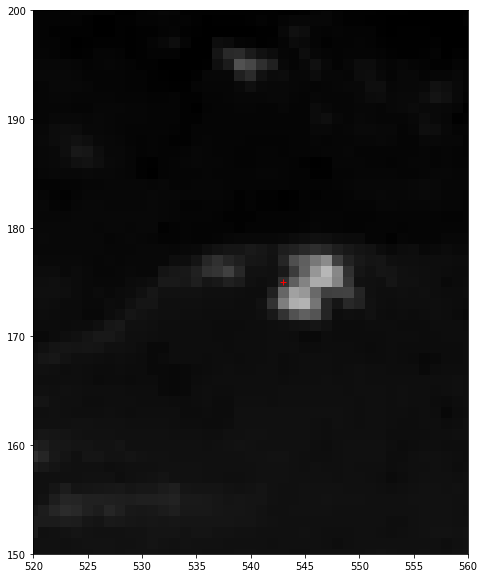

In [102]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(ir108_corrected,vmin=210,vmax=300,cmap='gray_r')
ax.plot(sat_start_col, sat_start_row,'r+')
ax.set_xlim(520,560)
ax.set_ylim(150,200)

In [88]:
track = tco.calculate_track(np.array(sat_data['IR_108']),(6,
                                                          sat_start_row,
                                                          sat_start_col),'dis',51)

In [89]:
track = track.assign(time=[t.strftime("%Y%m%d_%H%M") for t in time_steps])

In [90]:
track

time_step   row_index  column_index           time
0         -30  174.902505    540.605259  20130618_1225
1         -25  174.925182    540.812436  20130618_1230
2         -20  175.167100    541.301420  20130618_1235
3         -15  175.162052    541.733319  20130618_1240
4         -10  175.149767    541.972878  20130618_1245
5          -5  175.053757    542.492797  20130618_1250
6           0  175.000000    543.000000  20130618_1255
7           5  174.831654    543.190822  20130618_1300
8          10  174.641415    543.478296  20130618_1305
9          15  174.501151    543.938989  20130618_1310
10         20  174.296551    544.658462  20130618_1315
11         25  174.226010    545.289221  20130618_1320
12         30  173.953949    545.854285  20130618_1325

Die Bewegung scheint hier nicht allzu groß zu sein.

In [97]:
ir108_cutouts = []

In [98]:
for i, tv in track.iterrows():
    cutout = gi.cutout_field4box(sat_data['IR_108'][i],
                                 (int(np.rint(tv.row_index)),int(np.rint(tv.column_index))),51)
    ir108_cutouts.append(cutout)

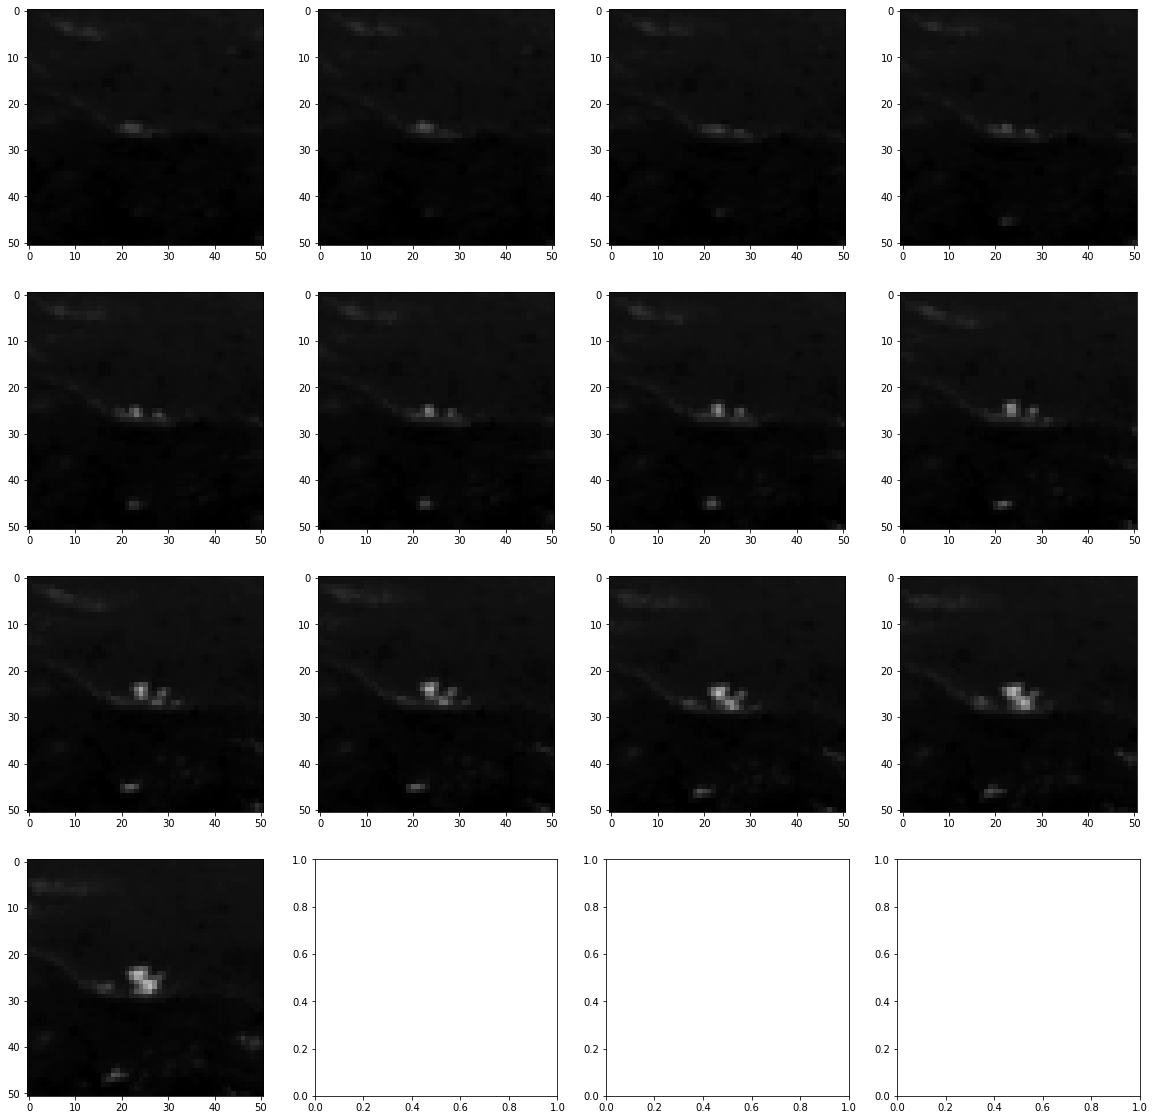

In [99]:
fig,ax = plt.subplots(4,4,figsize=(20,20))
axs = ax.ravel()
for i, f in enumerate(ir108_cutouts):
    axs[i].imshow(f,vmin=210,vmax=300,cmap='gray_r')